- 이미지 사이즈
- 분석 대상이 되는 객체의 위치
- RGB 채널별 통계 값
- target이 될 y에 대한 분석
- y는 저희가 맞추고자 하는 값이며 y값에 대한 특성은 어떤 것이 있을까요?? 
- y값에 독립적 분포 확인
    ex) y_1의 분포는?

- y값 들간의 관계 분포 확인
- ex) y_1, y_2 정보를 섞은 분포는?
- X, y 관계를 확인할 수 있는 분석
- X특성과 y의 특성 간의 분포 차이는 어떻게 있을까요??
- 이미지 사이즈와 y 특성의 관계
- RGB 통계값과 y 특성의 관계
- 객체의 위치와 y 특성의 관계
- 데이터의 노이즈 확인
    ex) y 값이 잘못 부여된것이 있을까??



In [ ]:
import pandas as pd
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# path
import os
train_dir = '../input/data/train'
train_meta = os.path.join(train_dir, "train.csv")
train_images_dir = os.path.join(train_dir, "images")

In [ ]:
meta_df = pd.read_csv(train_meta)
meta_df.sample(5)

In [ ]:
# meta with image_class
def define_mask_class(filename):
    if filename.startswith('mask'):
        return 0,filename
    elif filename.startswith('incorrect_mask'):
        return 1,filename
    elif filename.startswith('normal'):
        return 2,filename
    
def define_age_class(x):
    if x<30:
        return 0
    elif x>=30 and x<60:
        return 1
    else:
        return 2
    
meta_with_filename = pd.DataFrame(columns = ['path_file','path', 'mask',])

for path in tqdm(meta_df['path'].values):
    images = os.listdir(os.path.join(train_images_dir,path))
    
    for filename in images:
        if not filename.startswith('.'):
            mask_class,filename_ = define_mask_class(filename)
            meta_with_filename = meta_with_filename.append([{'path_file':os.path.join(path,filename_), 'path':path, 'mask':mask_class}])

meta_with_filename = pd.merge(left = meta_with_filename, right = meta_df, how = 'inner', on = 'path')
meta_with_filename['age_class'] = meta_with_filename['age'].apply(define_age_class)
meta_with_filename['gender'] = meta_with_filename['gender'].apply(lambda x : 0 if x=='male' else 1)
meta_with_filename['label'] = meta_with_filename.apply(lambda x : x['mask']*6 + x['gender']*3 + x['age_class'], axis=1)

meta_with_filename.sample(10)
    

# Y(meta) 에 대한 분석

In [ ]:
# variables
age = meta_with_filename['age'].values
gender = meta_with_filename['gender'].values

num_total = len(meta_with_filename)
num_wear = num_id *5
num_incorrect = num_id
num_not_wear = num_id

In [ ]:
meta_with_filename.info()

In [ ]:
meta_with_filename.describe(include='all')

null 값은 없지만 `id` 에서 중복값이 있다.

In [ ]:
from collections import Counter

id_overlap = (Counter(meta_with_filename['id'].values) - Counter(meta_with_filename['id'].unique())).elements()
meta_with_filename[meta_with_filename['id']==next(id_overlap)]

id는 같지만 나이가 다르다.
클래스가 다르진 않기 때문에 크리티컬하진 않다.

## age

In [ ]:
# age distribution
fig, axes = plt.subplots(1,2, figsize = (15,7))

x,y = np.unique(age, return_counts=True)
x_ = ['x < 30', '30< x <60', '60 < x']
y_ = [0,0,0]
for a, b in zip(x,y):
    if a < 30:
        y_[0] += b
    elif a >=30 and a<60:
        y_[1] += b
    else:
        y_[2] += b

xys = [(x,y),(x_,y_)]
titles = ['each ','grouped']
for ax,(x,y),title in zip(axes, xys, titles):
    ax.bar(x,y, color = 'darkgrey',linewidth = 1.5, edgecolor = 'black')
    ax.plot(x,y, color = 'black')
    ax.set_title(f'Num of Ages by {title}')
    ax.set_ylabel('# of age')
    ax.set_xlabel('ages')


60대 이상의 그룹이 다른 그룹에 비해 데이터가 부족하다.   
- 데이터 자체에 60살 까지밖에 표시가 안되어 있는데 이는 data description에 나온 70대 까지를 포함 한 것 인지 확인 할 필요가 있다.
- 60대 이상의 그룹에 대해서 data augmentation이 필요하다.


## gender

## age&gender

In [ ]:
# gender & age
group = meta_with_filename.groupby('gender')['age_class'].value_counts().sort_index()
idx = np.arange(len(group['male'].index))
width = 0.3
plt.figure(figsize=(12,7))   
plt.bar(idx - width/2, group['male'], 
        width=width, label = 'male', linewidth=1.,edgecolor='black',color = 'royalblue')
plt.bar(idx + width/2, group['female'],
        width = width, label = 'female',linewidth=1.,edgecolor='black', color = 'hotpink')
plt.xticks(idx)
plt.legend()
plt.title('# of Gender & age with ratio')

for i, m,f in zip(idx, group['male']/(group['male']+group['female']) , group['female']/(group['male']+group['female'])):
    plt.text(x = i - width/2, y= group['male'][i]+10, s=f'{m*10 :.1f}', ha='center',fontweight='bold')
    plt.text(x = i + width/2, y= group['female'][i]+10, s=f'{f*10:.1f}', ha='center',fontweight='bold')


        

연령 클래스별 남녀 비율은 30대 이하 그룹과 60대 이상그룹에서 `4.3 : 5.7` 로 평균보다 남성의 비율이 높게 나왔고   
30대이상 60대이하 그룹에서는 `3.3 : 6.7` 로 여성의 비율이 높게 나왔다. 

## Mask

In [ ]:
x = ['wear','incorrect','not wear']
y = [num_wear, num_incorrect, num_not_wear]

plt.figure(figsize=(12,7))
plt.bar(x,y,
        color = 'grey', width = 0.5,
        linewidth = 1.5, edgecolor = 'black' )
plt.title('# of mask_class')
for i in range(3):
    plt.text(x[i], y[i]-y[i]/1.8, s = y[i]/num_total, ha= 'center')

## overall

In [ ]:
x,y = np.unique(meta_with_filename['label'], return_counts=True)

plt.figure(figsize=(12,7))
plt.bar(x,y,color='darkgrey', edgecolor='black')
plt.title('# of label')
plt.xlabel('label')
plt.ylabel('count')
plt.xticks(x)

for x,y in zip(x,y):
    plt.text(x,y+50,s=y,ha='center')
plt.text(11,3500,s = 'label = mask*6 + gender*3 + age')

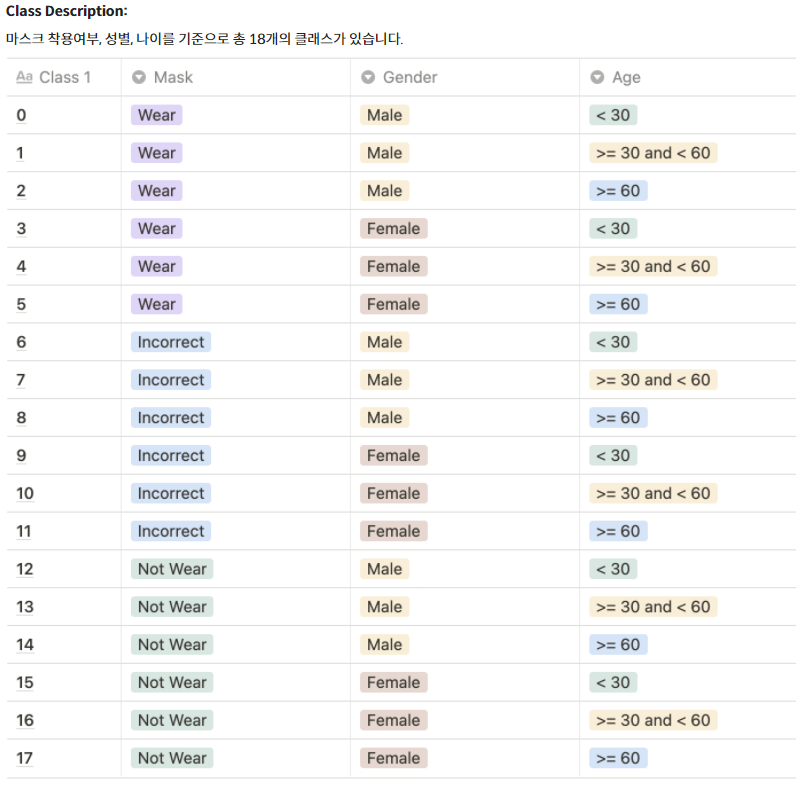

# X에 대한 분석(image)

In [ ]:
# sample 만 보자
from PIL import Image

n = 10
fig,axes = plt.subplots(1,n, figsize = (n*3,n//2))

sample_df = meta_with_filename.sample(n)
for i in range(n):
    img_path = os.path.join(train_images_dir, sample_df['path_file'].values[i])
    image_pil = Image.open(img_path)
    axes[i].axis('off')
    axes[i].imshow(image_pil)
    text_mask = sample_df['mask'].values[i]
    text_gender = sample_df['gender'].values[i]
    text_age = sample_df['age_class'].values[i]
    axes[i].set_title(f'm : {text_mask} / g : {text_gender} / a : {text_age}' )